In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.utils.data as Data
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

writer = SummaryWriter('runs/multi-features-LSTM')
# from torchvision import transforms, datasets
pd.set_option('display.max_columns', 1000)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from scipy.signal import savgol_filter
# Get data and remove outliers and minus values
def delete_outliers(data, filter):
    if filter:
        for attr in data.columns:
            data[attr] = pd.DataFrame(savgol_filter(data[attr], window_length=11, polyorder=3))

    data = data[data > 0].dropna()
    data.reset_index(drop=True, inplace=True)
    data_norm = (data - data.mean()) / (data.std())
    data = data[abs(data_norm[:]) <= 3].dropna().reset_index(drop=True)
    return data


def get_data(data_path, outliers, filter):
    data = pd.read_csv(data_path).dropna()
    data = data.sort_values('时间')
    attrs = ['叶绿素', '电导率', '溶解氧(mg/L)', '藻蛋白', '总溶解固体', '浊度', '温度', 'PH值']
    data['藻蛋白'] /= 100
    data = data[attrs]  # 8 features作为输入
    if outliers:
        data = delete_outliers(data, filter)
    label = data['藻蛋白']  # 藻蛋白作为target

    print(data.head())
    print(label.head())
    return data, label

In [4]:
data, label = get_data('./datasets/监测数据1/监测数据-独墅-20220809.csv',
                outliers=True, filter=False)

     叶绿素     电导率  溶解氧(mg/L)      藻蛋白   总溶解固体     浊度      温度   PH值
0  16.32  287.41       8.00  34.2167  162.96  12.59  32.319  8.76
1  16.33  291.48       8.02  34.3243  165.28  12.56  32.317  8.76
2  16.39  295.03       8.03  34.6086  167.29  12.56  32.316  8.77
3  16.42  295.25       8.05  34.7303  167.41  12.54  32.318  8.77
4  16.60  295.23       8.06  34.9762  167.39  12.59  32.320  8.78
0    34.2167
1    34.3243
2    34.6086
3    34.7303
4    34.9762
Name: 藻蛋白, dtype: float64


In [5]:
def split_windows(data, seq_length, normalize):
    data = np.array(data)
    x = []
    y = []
    for i in range(len(data) - seq_length):  # range的范围需要减去时间步长和1
        _x = data[i:(i + seq_length), :]
        _y = data[i + seq_length, -1]
        x.append(_x)
        y.append(_y)
    x = normalize_window(np.array(x), True) if normalize else np.array(x)
    y = normalize_window(np.array(y), False) if normalize else np.array(y)
    x, y = torch.tensor(x), torch.tensor(y)
    print('x.shape,y.shape=\n', x.shape, y.shape)
    return x, y


def normalize_window(x, x_or_y):
    # get normalized data
    if x_or_y:
        normalized_data = []
        for window in x:
            normalized_window = []
            for col_i in range(window.shape[1]):
                a = float(window[0, col_i])
                # print(a)
                normalized_col = [((float(p) / a) - 1) for p in window[:, col_i]]
                normalized_window.append(normalized_col)
            normalized_window = np.array(normalized_window).T
            normalized_data.append(normalized_window)
        return np.array(normalized_data)
    else:
        normalized_col = [(float(p) / x[0]) - 1 for p in x]
        return np.array(normalized_col)

In [6]:
x, y = split_windows(data, 10, True)

x.shape,y.shape=
 torch.Size([2151, 10, 8]) torch.Size([2151])


In [7]:
# # scale the data
# from sklearn.preprocessing import MinMaxScaler
# mm_x = MinMaxScaler(feature_range=(0,1))
# mm_y = MinMaxScaler(feature_range=(0,1))
# data_norm = mm_x.fit_transform(data.values)
# label_norm = mm_y.fit_transform(label.values.reshape(-1, 1))

In [8]:
# convert the x and y values into arrays
x, y = np.asarray(x), np.asarray(y)

In [9]:
# split the dataset into train and test sets
# transfer the nparray to variable so that the computation can be performed in GPU
def split_data(x, y, split_ratio):
    train_size = int(len(y) * split_ratio)
    test_size = len(y) - train_size

    x_data = Variable(torch.Tensor(x))
    y_data = Variable(torch.Tensor(y))

    x_train = Variable(torch.Tensor(x[0:train_size]))
    y_train = Variable(torch.Tensor(y[0:train_size]))
    y_test = Variable(torch.Tensor(y[train_size:len(y)]))
    x_test = Variable(torch.Tensor(x[train_size:len(x)]))

    print('x_data.shape,y_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape:\n{}{}{}{}{}{}'
          .format(x_data.shape, y_data.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape))

    return x_data, y_data, x_train, y_train, x_test, y_test

In [10]:
x_data, y_data, x_train, y_train, x_test, y_test = split_data(x, y, split_ratio=0.8)

x_data.shape,y_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape:
torch.Size([2151, 10, 8])torch.Size([2151])torch.Size([1720, 10, 8])torch.Size([1720])torch.Size([431, 10, 8])torch.Size([431])


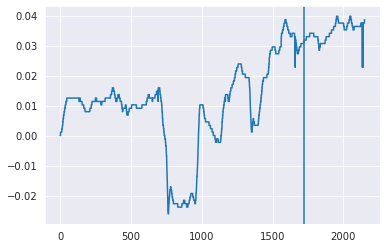

In [11]:
plt.plot(y)
plt.axvline(int(len(x)*0.8))

In [12]:
# 数据装入
def data_generator(x_train, y_train, n_iters, batch_size):
    num_epochs = n_iters / (len(x_train) / batch_size)  # n_iters代表一次迭代
    num_epochs = int(num_epochs)
    train_dataset = Data.TensorDataset(x_train, y_train)
    test_dataset = Data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False,
                                               drop_last=True)  # 加载数据集,使数据集可迭代
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                                              drop_last=True)

    return train_loader, test_loader, num_epochs

In [13]:
# Implement LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size) -> None:
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1  # 单向LSTM

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2).to(device)  # LSTM层
        self.fc = nn.Linear(hidden_size, output_size).to(device)  # 全连接层

    def forward(self, x):

        # initialize the hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # forward propagate
        out, (h_,c_) = self.lstm(x.to(device), (h0.to(device), c0.to(device)))

        out = self.fc(out)[:,-1,:]
        return out

In [14]:
# define the parameters and model
input_size = 8
output_size = 1
num_layers = 8
hidden_size = 12
batch_size = 64
n_iters = 10000
lr = 0.001

train_loader, test_loader, num_epochs = data_generator(x_train.to(device), y_train.to(device), n_iters, batch_size)
lstm = LSTM(input_size, hidden_size, num_layers, output_size, batch_size).to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)
print('finish')

finish


In [15]:
# model training
iter = 0
running_loss = 0.0
for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(train_loader):
        outputs = lstm(batch_x)
        optimizer.zero_grad()  # 将每次传播时的梯度累积清除
        # print(outputs.shape, batch_y.shape)
        loss = criterion(outputs, batch_y)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()

        running_loss += loss.item()
        iter += 1
        if iter % 100 == 0:
            writer.add_scalar('training loss',
                              running_loss / 100,
                              epoch * len(train_loader) + i)
            running_loss = 0.0
            print("iter: %d, loss: %1.5f" % (iter, loss.item()))
print(x_data.shape)
writer.add_graph(lstm, x_test)
writer.close()

/home/weiyichen/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter: 100, loss: 0.00025
iter: 200, loss: 0.00019
iter: 300, loss: 0.00192
iter: 400, loss: 0.00012
iter: 500, loss: 0.00006
iter: 600, loss: 0.00006
iter: 700, loss: 0.00096
iter: 800, loss: 0.00045
iter: 900, loss: 0.00020
iter: 1000, loss: 0.00057
iter: 1100, loss: 0.00006
iter: 1200, loss: 0.00001
iter: 1300, loss: 0.00106
iter: 1400, loss: 0.00002
iter: 1500, loss: 0.00006
iter: 1600, loss: 0.00152
iter: 1700, loss: 0.00003
iter: 1800, loss: 0.00001
iter: 1900, loss: 0.00004
iter: 2000, loss: 0.00075
iter: 2100, loss: 0.00035
iter: 2200, loss: 0.00017
iter: 2300, loss: 0.00045
iter: 2400, loss: 0.00003
iter: 2500, loss: 0.00000
iter: 2600, loss: 0.00095
iter: 2700, loss: 0.00001
iter: 2800, loss: 0.00007
iter: 2900, loss: 0.00142
iter: 3000, loss: 0.00001
iter: 3100, loss: 0.00001
iter: 3200, loss: 0.00004
iter: 3300, loss: 0.00065
iter: 3400, loss: 0.00029
iter: 3500, loss: 0.00016
iter: 3600, loss: 0.00041
iter: 3700, loss: 0.00002
iter: 3800, loss: 0.00000
iter: 3900, loss: 0.0

(2151, 1)
(1720, 1)
(431, 1)


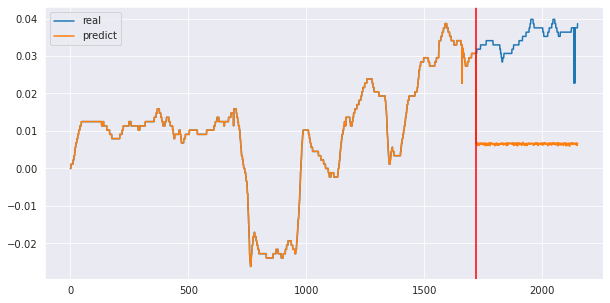

In [18]:
# testing the predction model on multiple time series
last_x = x_train.cpu()[-1].view(80)
prediction_val = []

while len(prediction_val)<len(y_test):
    prediction = lstm(last_x.view(1,10,8)).cpu()
    prediction_val.append(prediction[0,0].item())

    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

y_data_plot = y_data.data.cpu().numpy()
y_data_plot = np.reshape(y_data_plot, (-1, 1))
# y_data_plot = mm_y.inverse_transform(y_data_plot)
y_train_plot = y_train.data.cpu().numpy()
y_train_plot = np.reshape(y_train_plot, (-1, 1))
# y_train_plot = mm_y.inverse_transform(y_train_plot)
# data_predict = mm_y.inverse_transform(np.reshape(prediction_val, (-1, 1)))
data_predict = np.reshape(prediction_val, (-1, 1))
print(y_data_plot.shape)
print(y_train_plot.shape)
print(data_predict.shape)
# plot the result
plt.figure(figsize=(10, 5))
plt.plot(y_data_plot)
plt.plot(np.concatenate((y_train_plot, data_predict), axis=0))
plt.axvline(int(len(x)*0.8), color='red')
plt.legend(('real', 'predict'), fontsize='10')

In [17]:
print('MAE/RMSE')
print(mean_absolute_error(y_data_plot[-len(data_predict):], data_predict))
print(np.sqrt(mean_squared_error(y_data_plot[-len(data_predict):], data_predict)))
print('R2: %.3f' % r2_score(y_data_plot[-len(data_predict):], data_predict))

MAE/RMSE


NameError: name 'data_predict' is not defined